In [1]:
import pandas as pd
import numpy as np
import boto3, os, io, joblib
from sagemaker import get_execution_role
from datetime import datetime
from plotnine import ggplot, ggtitle, geoms, aes, theme_classic, scales, theme, labels, element_blank

In [2]:
role = get_execution_role()
connection = boto3.client('s3')
bucket = 'ascsagemaker'

### read in processed data

In [3]:
contents = connection.list_objects(Bucket=bucket,
                                   Prefix='JMP_congressional_nmf/dtms')['Contents']

filenames = [i['Key'] for i in contents]
years = [i.split('/')[-1][:3] for i in filenames if i.endswith('csv')]

In [4]:
def data_onboard(year):
    file_key = 'JMP_congressional_nmf/dtms/{}{}'
    data = {}
    data['csv'] = pd.read_csv(connection.get_object(Bucket=bucket,
                                       Key = file_key.format(year,'.csv'))['Body'])
    
    data['pkl'] = joblib.load(io.BytesIO(
                        connection.get_object(Bucket=bucket,
                                              Key=file_key.format(year,'.pkl'))['Body'].read()
    ))
    
    return data

### Data description

need a function that gives basic descriptions and graphs for understanding the data
* shape of csv
* number of speeches from each chamber
* date-range and distribution of speeches over time
* word_count summary and plot
* DTM shape
* vocabulary size

In [5]:
def describe_data(data):
    
    df,pkl = data.values()
    
    # df descriptives
    chamber_counts = df.loc[-df.chamber.isin(['E','None'])].chamber.value_counts()
    print("TOTAL SPEECHES -- {}\n".format(len(df.loc[-df.chamber.isin(['E','None'])])))
    print("Chamber Counts")
    print(chamber_counts)
    df['date'] = [datetime.strptime(i,'%Y-%m-%d') for i in df['date']]
    
    weekly_counts = (df.loc[-df.chamber.isin(['E','None'])]
           .groupby(['chamber',pd.Grouper(key='date', freq='D')])['word_count']
           .count()
           .reset_index()
           .sort_values('date')
           .dropna()
    )
    
    min_date = datetime.strftime(df['date'].min(),'%Y')
    max_date = datetime.strftime(df['date'].max(),'%Y')

    A = (
        ggplot(weekly_counts,aes(x = 'date',y = 'word_count',color='chamber',group='chamber')) + 
        geoms.geom_line() +
        theme_classic() + 
        theme(figure_size=(12,1)) + 
        scales.scale_color_manual(values=['green','purple']) +
        labels.ylab('Number of Speeches') +
        ggtitle(f'Daily Speech Counts for Chambers, {min_date} - {max_date}')
    )
    
    B = (
    ggplot(df.loc[-df.chamber.isin(['None','E'])],aes(x = "chamber",y='word_count',fill='chamber')) +
    geoms.geom_boxplot() +
    theme_classic() +
    theme(legend_position=None,
          figure_size=(4,4)) +
    scales.scale_fill_manual(values=['green','purple']) +
    ggtitle(f'Speech Length, {min_date}-{max_date}')
    )
    
    display(A)\
    
    display(B)
    
    print(df.loc[-df.chamber.isin(['None','E'])].word_count.describe())
    
    print(f"\nVOCAB SIZE: {pkl['dtm'].shape[1]}")
    return weekly_counts,df

In [6]:
def run_diagnostic(year):
    data = data_onboard(year)
    return describe_data(data)

In [7]:
years[8]

'106'

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


TOTAL SPEECHES -- 84770

Chamber Counts
S    46655
H    38115
Name: chamber, dtype: int64


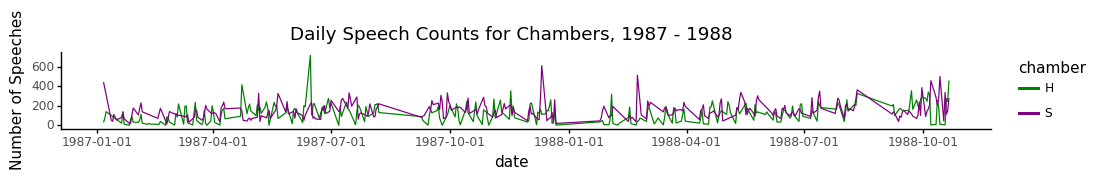

<ggplot: (8740173263992)>

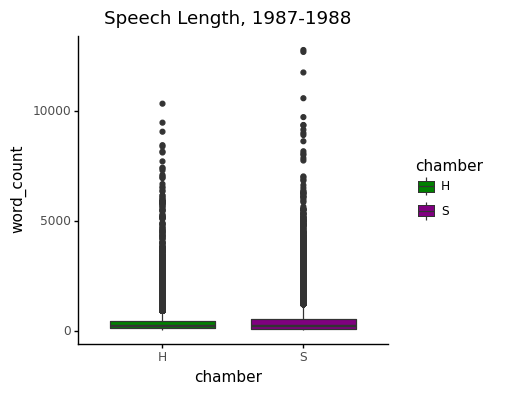

<ggplot: (-9223363296683528062)>

count    84770.000000
mean       403.315631
std        515.702762
min         50.000000
25%        113.000000
50%        246.000000
75%        494.000000
max      12766.000000
Name: word_count, dtype: float64

VOCAB SIZE: 18448


In [12]:
X,z = run_diagnostic(years[3])

In [11]:
len(years)

17